# Is there a statistical difference between the ratings of two different music genres?


## Introduction

In order to run our Hypothesis Testing Analysis, we will :
- [Make an Observation](#Observation)
- [Examine the Reseach](#Previous-Research)
- [Form a Hypothesis](#Hypothesis-Formulation)
- [Conduct an Experiment](#Experiment)
- [Analyse Experimental Results](#Analysis)
- [Draw Conclusions](#Conclusions)

## Observation

Our goal here is to find out if we can detect any bias in the way Pitchfork editorial team scores the reviewed albums from a specific genre. Our expectation is that there is no differences between genre in terms of scores distribution. But as researches show on different editorial topic and especially political news, there is a lot of bias when presenting facts.

## Previous Research

Googling "Editorial bias" brings up lots of results about content bias. Bellow I have listed a few links explaining the phenomena and further documentations:
* https://libguides.usc.edu/evaluate/bias
* https://en.wikipedia.org/wiki/Media_bias
* https://www.allsides.com/unbiased-balanced-news

## Hypothesis Formulation

So going back to our observation, bellow are our Alternative Hypothesis and Null Hypothesis :

**Ha** : The is no significant scoring difference between genres.

**Ho** : There is a significant difference between genres.


## Experiment

Our experiment have already been done by Nolan Conaway 2 years ago. He conduct the experiment by scraping over 18,000 Pitchfork reviews from 1999 to 2017. The detailed process is explained [source](https://www.kaggle.com/nolanbconaway/pitchfork-data) as well as the resulting sqlite reviews database. 
The dataset contains :

Table | Total Rows | Total Columns | Columns
--- | :- | :--- | :---:
artists | 18831 | 2 | reviewid, artist
content | 18393 | 2 | reviewid, content
genres | 22680 | 2 | reviewid, genre
labels | 20190 | 2 | reviewid, label
reviews | 18393 | 13 | reviewid, title, artist, url, score, best_new_music, author, author_type, pub_date, pub_weekday, pub_day, pub_month, pub_year
years | 19108 | 2 | reviewid, year


## Analysis


In [20]:
# Import necessary librairies
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import random


import seaborn as sns
sns.set(color_codes=True)

### Exploritary Data Analysis (EDA)

In the following blocks, we are going to explore our Pitchfork data. Looking for any outliers, gap between distributions etc...

In [21]:
# Connect to Pitchfork database
conn = sqlite3.Connection('database.sqlite')
c = conn.cursor()

#### General overview

In [22]:
# Retrieve list of distinct genres. Looking for any disparity between number of observations per genre.
# Main focus here is to look at number of reviews / number of best music flags per genre
c.execute("""
SELECT g.genre, AVG(r.score) as avg_score, COUNT(r.reviewid) as review_counter, SUM(r.best_new_music) as best_music_counter
FROM reviews as r, years as y, labels as l, genres as g
WHERE r.reviewid = y.reviewid
AND r.reviewid = l.reviewid
AND r.reviewid = g.reviewid
GROUP BY g.genre
ORDER BY avg_score DESC;
""")
genre_score_df = pd.DataFrame(c.fetchall())
genre_score_df.columns = [x[0] for x in c.description]
genre_score_df


,genre,avg_score,review_counter,best_music_counter
0,global,7.416418,268,12
1,experimental,7.371575,2044,158
2,jazz,7.341129,496,24
3,folk/country,7.226963,764,31
4,None,7.052846,2653,64
5,rock,6.991398,10858,737
6,metal,6.989896,960,31
7,electronic,6.935706,4341,244
8,pop/r&b,6.928631,1666,124
9,rap,6.904380,1872,114


In [24]:
# Observations: Each genre has at least 268 observations.
# This would allow us to conduct experiments per genre with confidence. Also, It looks like we have an empty genre "None"
# In the next step, we are going to investigate for Null/NA values.

#### Data cleaning - Dealing with NA values

In [23]:
# Retrieving all the reviews with their associated genre
c.execute("""
SELECT g.genre, r.*
FROM reviews as r, genres as g
WHERE r.reviewid = g.reviewid;
""")
reviews_df = pd.DataFrame(c.fetchall())
reviews_df.columns = [x[0] for x in c.description]
reviews_df.head()

,genre,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,electronic,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,metal,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,rock,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,rock,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,electronic,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [28]:
# DataFrame Overview
reviews_df.describe()

# Observations : Some reviews have no score - needs further investigation. The others values looks OK.

,reviewid,score,best_new_music,pub_weekday,pub_day,pub_month,pub_year
count,22690.000000,22690.000000,22690.000000,22690.000000,22690.000000,22690.000000,22690.000000
mean,12034.507977,6.991155,0.049890,2.107404,15.537373,6.276069,2008.446584
std,6234.605984,1.305532,0.217722,1.640818,8.764822,3.311968,4.552492
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1999.000000
25%,7103.250000,6.400000,0.000000,1.000000,8.000000,3.000000,2005.000000
50%,12426.000000,7.200000,0.000000,2.000000,15.000000,6.000000,2008.000000
75%,17062.750000,7.800000,0.000000,3.000000,23.000000,9.000000,2012.000000
max,22745.000000,10.000000,1.000000,6.000000,31.000000,12.000000,2017.000000


In [53]:
# Looking at null scores
reviews_df[reviews_df['score'] == reviews_df.score.min()].count()

# Observations : Only 7 values out of 18,0000. We are keeping them.

genre             6
reviewid          7
title             7
artist            7
url               7
score             7
best_new_music    7
author            7
author_type       6
pub_date          7
pub_weekday       7
pub_day           7
pub_month         7
pub_year          7
dtype: int64

In [56]:
# Looking at NA genre values
reviews_df.genre.isna().sum()

# Observations : There is 2371 reviews with no genre assigned. This is quite large compared with the total 
# number of reviews. Normally we wouldn't remove them but as we are conducting an analysis on genre we are going to 
# remove them. No genre would not allow us to say if there is a bias on genre.

2371

In [60]:
# Removing reviews with no genre assigned
reviews_df.dropna(subset=['genre'], inplace=True)
reviews_df.genre.isna().sum()

0

### Normality Check - Plotting score per genre along with normality check

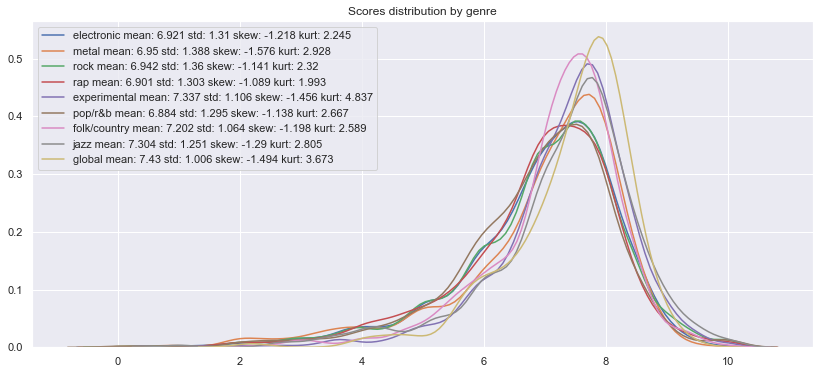

In [96]:
# Display scoring distribution by genre to see significant effect size in distribution means.

# Retrieve and store list of genres
genres = reviews_df['genre'].unique()

# Define our plot function
def plot_distribution(ds: pd.DataFrame, label: str):
    '''
    Plot pandas DataSerie distribution along with the skewness and kurtosis measure. 
    '''
    # skewness and kurtosis
    skew = round(stats.skew(ds), 3)
    kurtosis = round(stats.kurtosis(ds), 3)
    
    # Mean and variance
    mu = round(ds.mean(), 3)
    std = round(ds.std(), 3)

    # Plot dataset distribution
    sns.kdeplot(ds, label='{} mean: {} std: {} skew: {} kurt: {}'.format(label, mu, std, skew, kurtosis))

# Plot our genre distributions
fig = plt.figure(figsize=(14,6))
for genre in genres:
    # Retrieve genre dataset
    genre_df = reviews_df[reviews_df['genre'] == genre]
    plot_distribution(genre_df['score'], genre)

# Set title and legends
plt.legend()
plt.title('Scores distribution by genre');

In [81]:
# Observations : The distributions don't look normal but slightly negatively skewed. The kurtosis are around 3 which 
# complies with normality kurtosis.
# In our next steps we will try to remove any outliers and do some log transformation to see if we can normalize the data

In [88]:
# Removing the 1% lowest scores
reviews_df['score'].quantile(.01)

2.6

In [89]:
# remove outliers
trimmed_reviews_df = reviews_df.loc[reviews_df['score'] > reviews_df['score'].quantile(.01)]
trimmed_reviews_df.head()

,genre,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,electronic,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,metal,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,rock,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,rock,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,electronic,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


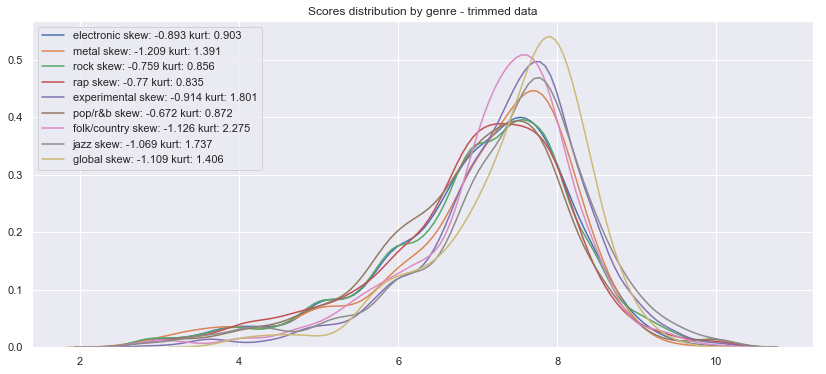

In [90]:
# Plot distribution without outliers
fig = plt.figure(figsize=(14,6))
for genre in genres:
    # Retrieve genre dataset
    genre_df = trimmed_reviews_df[trimmed_reviews_df['genre'] == genre]
    plot_distribution(genre_df['score'], genre)
    
plt.legend()
plt.title('Scores distribution by genre - trimmed data');

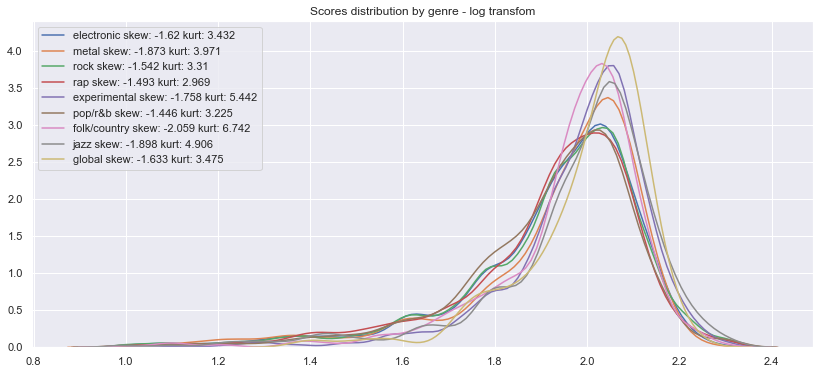

In [92]:
# Normalizing distribution with log transform
fig = plt.figure(figsize=(14,6))
for genre in genres:
    # Retrieve genre dataset
    genre_df = trimmed_reviews_df[trimmed_reviews_df['genre'] == genre]
    genre_array = np.array(genre_df['score'])
    genre_array_log = np.log(genre_array)
    plot_distribution(genre_array_log, genre)

plt.legend()
plt.title('Scores distribution by genre - log transfom');

In [97]:
# Conclusion: Trying to normalise genre distribution doesn't seem to help and it might be difficult to use traditional 
# z-test
# As we have seen, a KS-Test or Kolmogorov-Smirnov Test might be more appropriate in order to compare to non normal 
# distributions

### The KS-Test : Comparing 2 genres not normally distributed

As we have seen, a KS-Test or Kolmogorov-Smirnov Test might be more appropriate in order to compare to non normal 
distributions

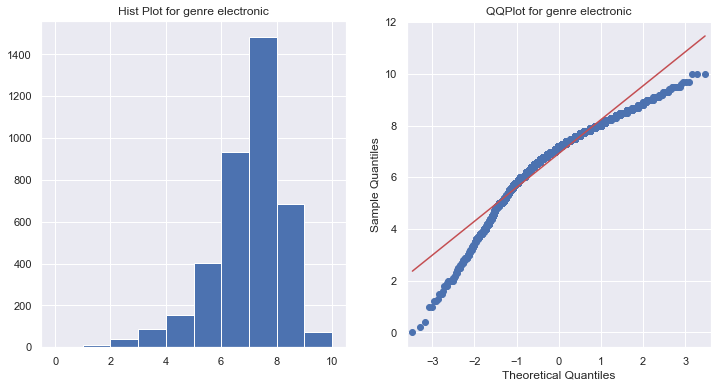

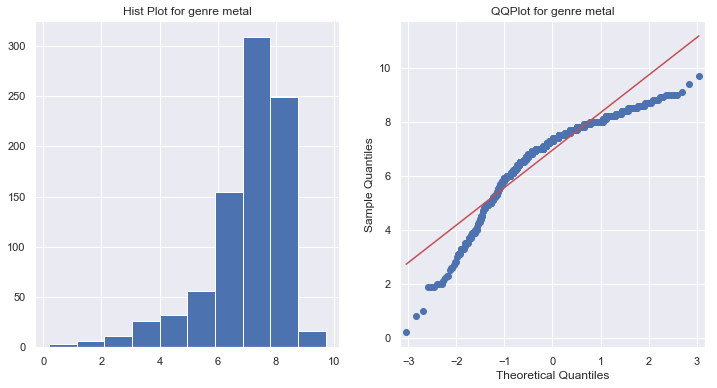

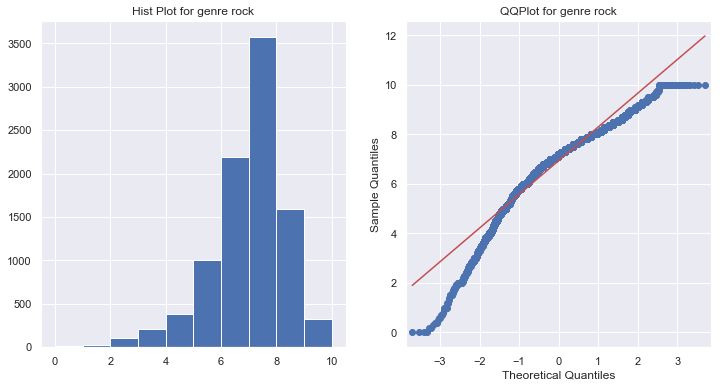

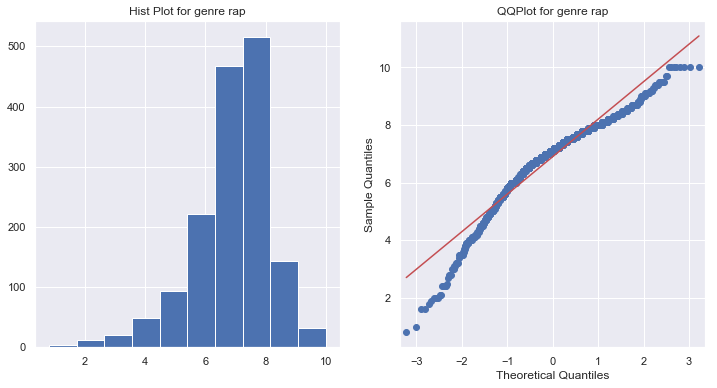

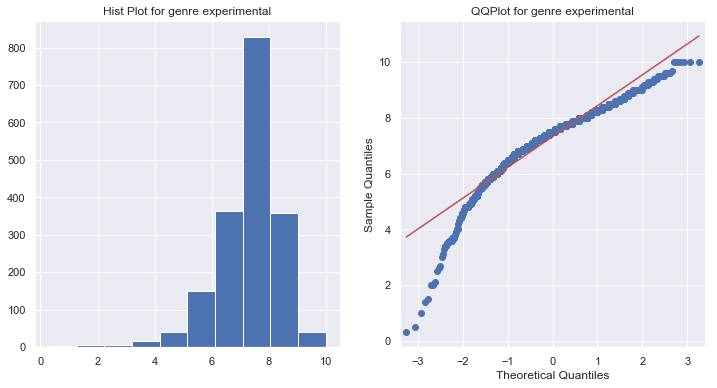

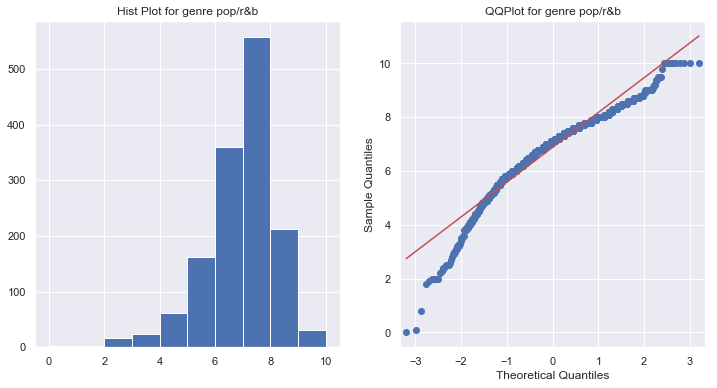

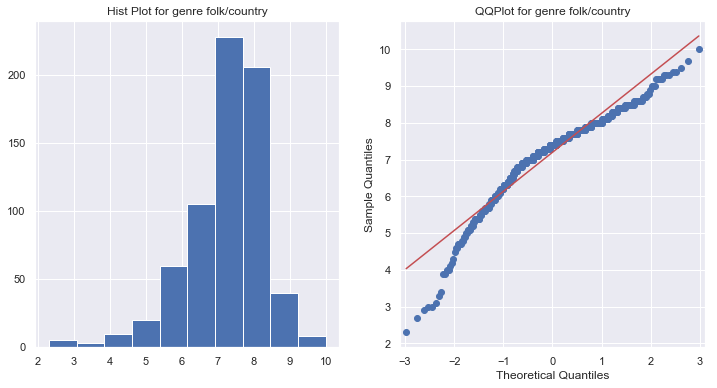

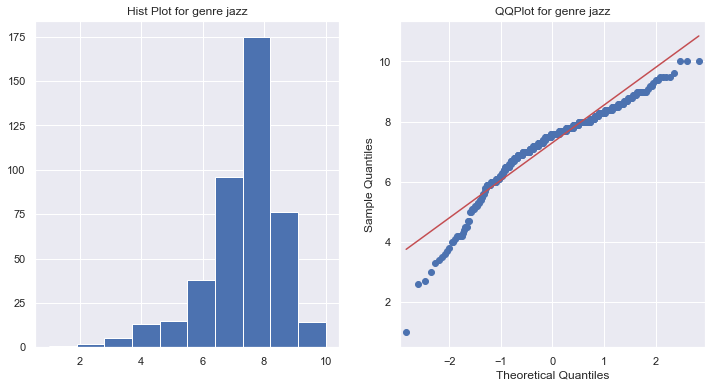

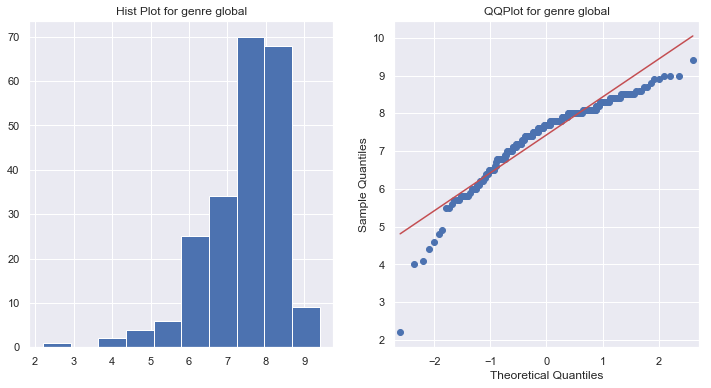

In [99]:
# Let's plot a Hist/QQPlot of our genre distributions to double check that we are not dealing with normal distributions.
import statsmodels.api as sm

# Plot histograms and QQplots for above datasets
for genre in genres:
    fig, axes = plt.subplots(1,2, figsize=(12,6))
    # Retrieve genre dataset
    genre_df = reviews_df[reviews_df['genre'] == genre]

    # Histogram + QQPlot
    axes[0].hist(genre_df['score'])
    axes[0].set_title('Hist Plot for genre {}'.format(genre));

    sm.qqplot(genre_df['score'], line='s', ax=axes[1])
    axes[1].set_title('QQPlot for genre {}'.format(genre));
    plt.show()


In [122]:
# Conclusions: Looking at both hist and QQplot (compared against normal distribution),
# we can say with more confidence that the data are not normal.

In [199]:
# Run the 2 samples KS test
# Plot genres CDFs for "Rap" vs "Experimental" 

def ks_plot_2sample(data_1, data_2, label_1, label_2, ax):
    '''
    Data entereted must be the same size.
    '''
    # Run the two sample KS test on genre & genre2
    ktest_result = stats.ks_2samp(sample_1, sample_2)
    
    ax.plot(np.sort(data_1), np.linspace(0,1,len(data_1)), label=label_1)
    ax.plot(np.sort(data_2), np.linspace(0,1,len(data_2)), label=label_2)
    ax.legend()
    ax.set_title('Comparing {} vs {} CDFs for KS-Test - pvalue {}'.format(label_1, label_2, round(ktest_result.pvalue, 3)))


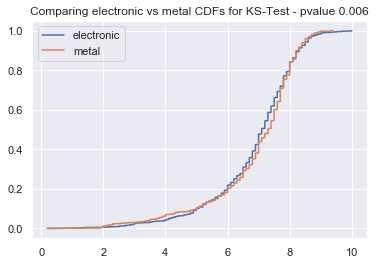

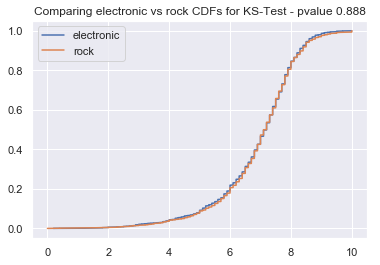

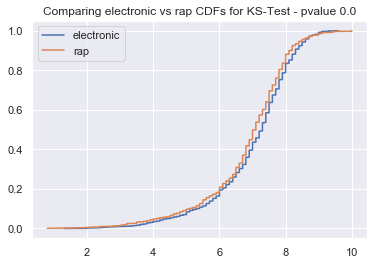

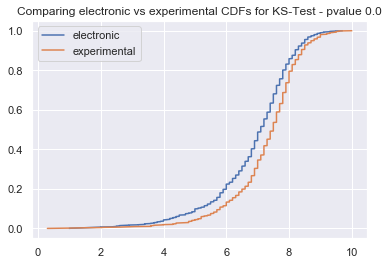

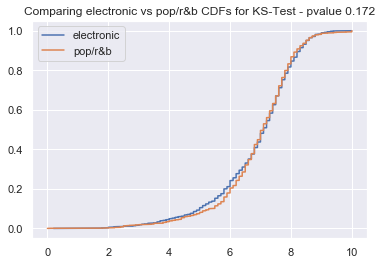

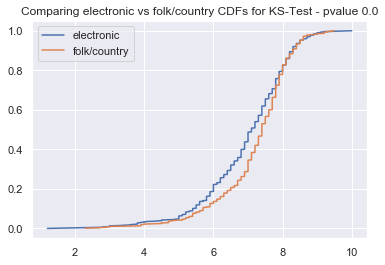

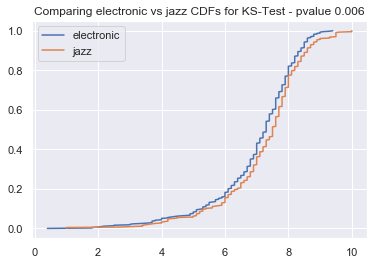

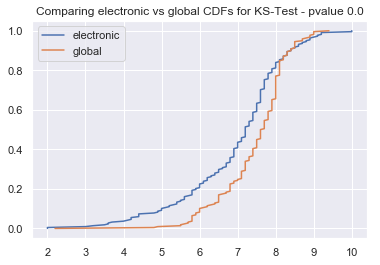

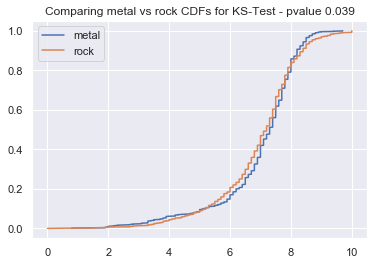

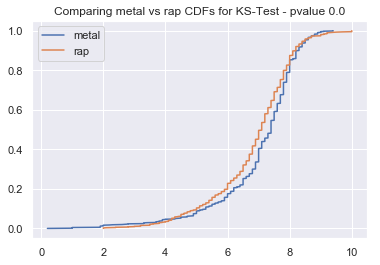

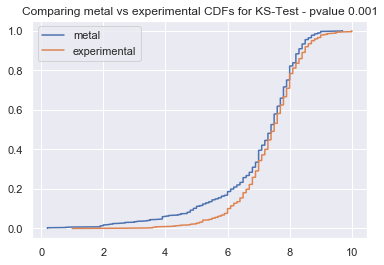

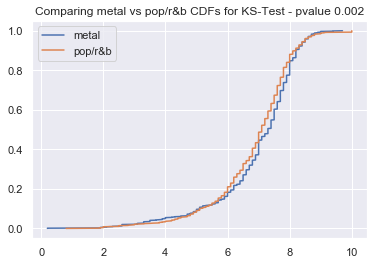

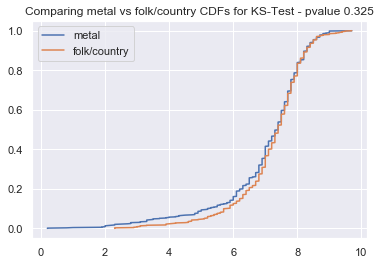

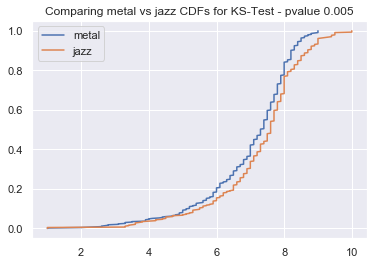

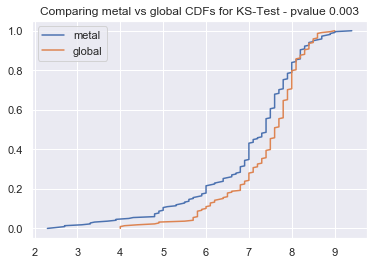

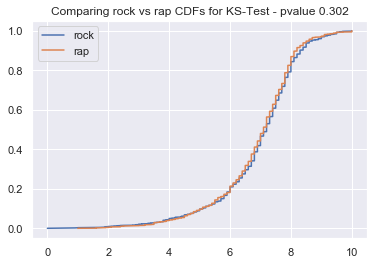

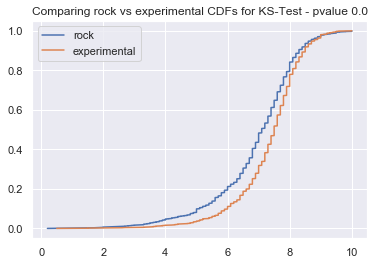

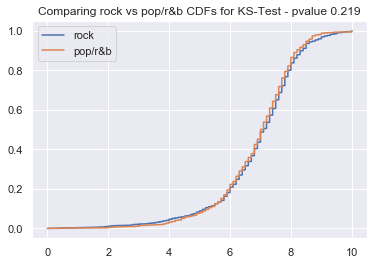

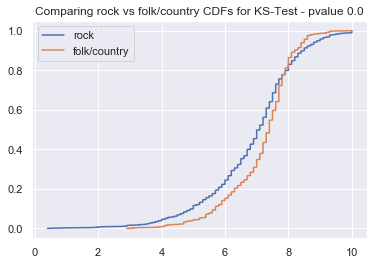

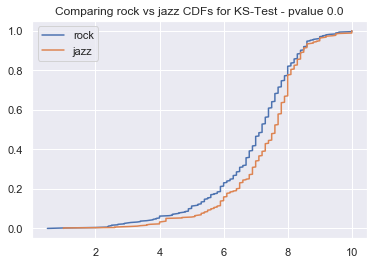

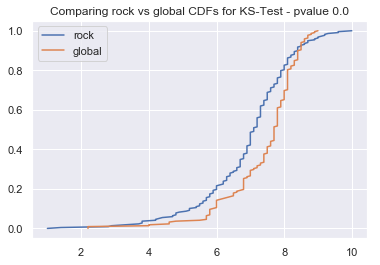

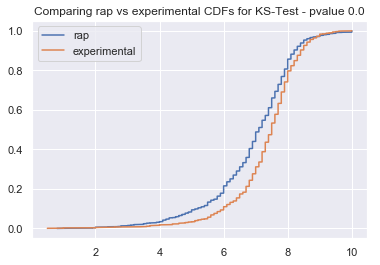

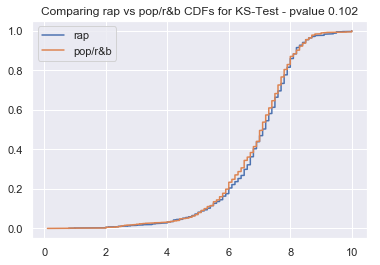

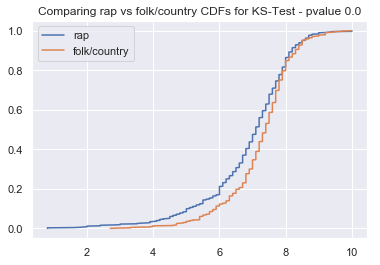

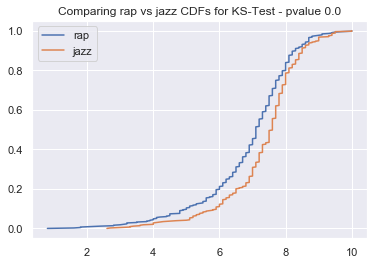

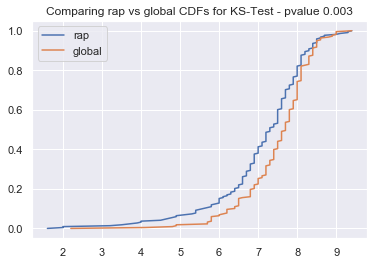

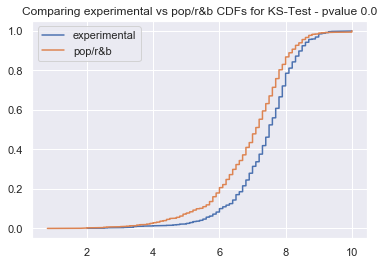

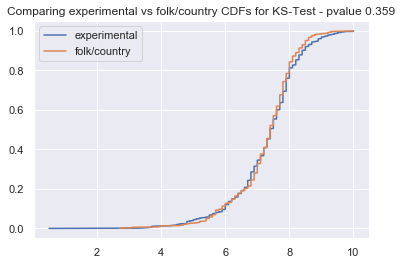

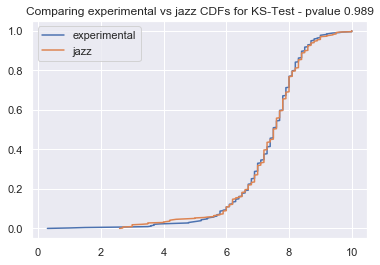

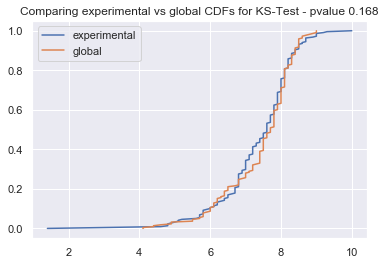

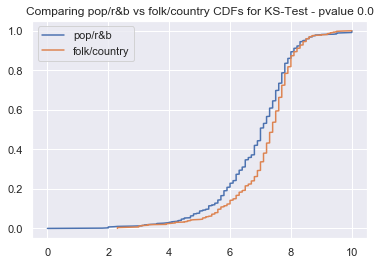

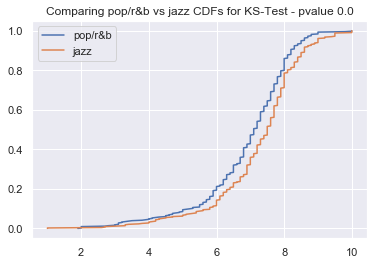

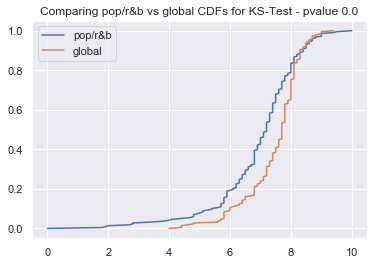

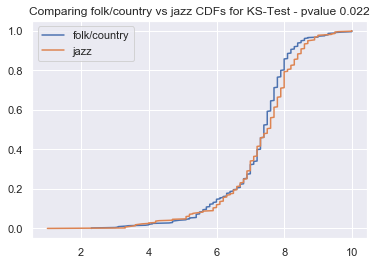

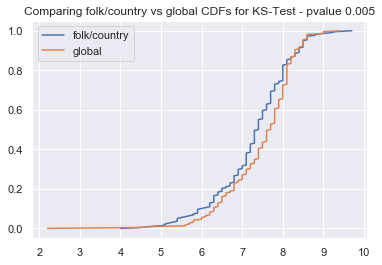

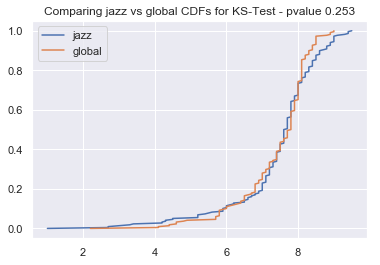

In [220]:
import itertools

combos = itertools.combinations_with_replacement(genres, 2)

# Storing KS-Test results
ks_results = []

for comb in combos:
    genre = comb[0]
    genre2 = comb[1]
    
    if genre != genre2:
        ax = plt.axes()

        # Retrieve genre dataset
        genre_score_ds = reviews_df[reviews_df['genre'] == genre]['score']
        genre2_score_ds = reviews_df[reviews_df['genre'] == genre2]['score']

        genre_min_len = min(len(genre_score_ds), len(genre2_score_ds))

        sample_1 = np.random.choice(genre_score_ds, genre_min_len)
        sample_2 = np.random.choice(genre2_score_ds, genre_min_len)

        # Run the two sample KS test on genre & genre2
        ktest_result = stats.ks_2samp(sample_1, sample_2)
        ks_results.append([genre, genre2, ktest_result.pvalue, ktest_result.statistic, genre_score_ds.mean(), genre2_score_ds.mean()])

        # KS Plot
        ks_plot_2sample(sample_1, sample_2, genre, genre2, ax)

        # Plot our graphs
        plt.show();

    

In [221]:
# Display KS results
ks_results_df = pd.DataFrame(ks_results, columns=['genre', 'genre2', 'pvalue', 'statistic', 'genre_mean', 'genre2_mean'])
ks_results_df.sort_values(by='pvalue', ascending=True)

,genre,genre2,pvalue,statistic,genre_mean,genre2_mean
16,rock,experimental,1.419694e-22,0.166942,6.942011,7.336694
21,rap,experimental,1.113091e-21,0.176395,6.900513,7.336694
26,experimental,pop/r&b,5.104974e-20,0.176676,7.336694,6.883799
3,electronic,experimental,5.504644e-17,0.144353,6.920702,7.336694
30,pop/r&b,folk/country,3.188508e-09,0.170803,6.883799,7.202190
20,rock,global,1.708552e-08,0.287671,6.942011,7.429680
32,pop/r&b,global,1.677496e-07,0.269406,6.883799,7.429680
5,electronic,folk/country,3.040857e-07,0.150365,6.920702,7.202190
18,rock,folk/country,4.118531e-07,0.148905,6.942011,7.202190
24,rap,jazz,4.334698e-07,0.186207,6.900513,7.303908


In [222]:
# Filter the KS results with p value < 0.05 meaning that we can reject the Null Hypothesis with 95% confidence.
# In other terms, the score between those genre are highly differents.
ks_results_rejecting_null_hypo_df = ks_results_df[ks_results_df['pvalue'] < .05]
ks_results_rejecting_null_hypo_df

,genre,genre2,pvalue,statistic,genre_mean,genre2_mean
0,electronic,metal,6.344730e-03,0.081206,6.920702,6.950000
2,electronic,rap,5.860771e-05,0.081462,6.920702,6.900513
3,electronic,experimental,5.504644e-17,0.144353,6.920702,7.336694
5,electronic,folk/country,3.040857e-07,0.150365,6.920702,7.202190
6,electronic,jazz,5.777711e-03,0.114943,6.920702,7.303908
7,electronic,global,1.529320e-04,0.205479,6.920702,7.429680
8,metal,rock,3.851678e-02,0.067285,6.950000,6.942011
9,metal,rap,8.027325e-07,0.129930,6.950000,6.900513
10,metal,experimental,7.452736e-04,0.095128,6.950000,7.336694
11,metal,pop/r&b,2.268410e-03,0.088167,6.950000,6.883799


In [225]:
# Counting the number of time a genre appears in the list. Giving an idea of how often the genre is rated differently
genre_dict = {}
for genre in genres:
    query = 'pvalue < .05 & ((genre == "{}" & genre_mean > genre2_mean) | (genre2 == "{}" & genre_mean < genre2_mean))'.format(genre, genre)
    genre_df = ks_results_df.query(query)
    genre_dict[genre] = len(genre_df)
genre_dict

{'electronic': 1,
 'metal': 4,
 'rock': 0,
 'rap': 0,
 'experimental': 5,
 'pop/r&b': 0,
 'folk/country': 4,
 'jazz': 6,
 'global': 6}

In [226]:
genre_dict = {}
for genre in genres:
    query = 'pvalue < .05 & ((genre == "{}" & genre_mean < genre2_mean) | (genre2 == "{}" & genre_mean > genre2_mean))'.format(genre, genre)
    genre_df = ks_results_df.query(query)
    genre_dict[genre] = len(genre_df)
genre_dict

{'electronic': 5,
 'metal': 3,
 'rock': 5,
 'rap': 6,
 'experimental': 0,
 'pop/r&b': 5,
 'folk/country': 2,
 'jazz': 0,
 'global': 0}

## Conclusions

As we have seen we can say with 95% that some genres are distinct distributions and others are pretty similar. 

The genre most highly rated are jazz, global, experimental when compared to the others. On the other hand Rap, electronic, pop/R&B and rock are more likely to be rated less than the other genres.